In [1]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.stats import norm,multivariate_normal
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from tqdm import tqdm
from numpy.fft import fft, ifft
from scipy.signal import correlate2d
from matplotlib import rc
#Direct input 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 20,
          'legend.fontsize': 20,
          'legend.handlelength': 2,
          'font.family' : 'sans-serif',
          'font.sans-serif':['Helvetica'],
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if rd not in sys.path:
    sys.path.append(rd)

# from models.singly_constrained.spatial_interaction_model import SpatialInteraction

/Users/Yannis/.pyenv/versions/3.7.5/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


# Import data

In [16]:
dataset = 'commuter_ward'
constrained = 'singly'

# Cost matrix file
cm = 'sn'

cost_matrix_file_extension = ''
if cm == 'sn':
    cost_matrix_file_extension = '_small_network'

In [17]:
# Import commuter Borough to Borough data
cost_matrix = np.loadtxt(os.path.join(rd,f'data/input/{dataset}/cost_matrix{cost_matrix_file_extension}.txt'))
origin_supply = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/origin_supply.txt'))
initial_destination_sizes = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/initial_destination_sizes.txt'))

o = origin_supply/np.sum(origin_supply)
c = cost_matrix/np.sum(cost_matrix)
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
wd = np.exp(xd)

orig_locs = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/origin_locations.txt'))
dest_locs = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/destination_locations.txt'))

london_boundary = gpd.read_file('../data/input/misc/london_boundary.geojson')
borough_polygons = gpd.read_file('../data/input/misc/borough_coordinates.json'.format(dataset))
ward_polygons = gpd.read_file('../data/input/misc/ward_coordinates.json'.format(dataset))

actual_destination_demand = np.loadtxt(os.path.join(rd,f'./data/validation/commuter/borough_destination_demand.txt'))
d = actual_destination_demand/np.sum(actual_destination_demand)

actual_origin_supply = np.loadtxt(os.path.join(rd,f'./data/validation/commuter/borough_origin_supply.txt'))
ao = actual_origin_supply/np.sum(actual_origin_supply)

ward_to_borough_origin_supply = np.loadtxt(os.path.join(rd,f'./data/input/commuter_ward/origin_supply_borough.txt'))
bo = ward_to_borough_origin_supply/np.sum(ward_to_borough_origin_supply)

N,M = cost_matrix.shape

alpha = 1.2
beta = 1400
delta = np.min(np.exp(xd))
gamma = 100
kappa = 1 + delta*M
epsilon = 1
theta = np.array([alpha,beta,delta,gamma,kappa,epsilon])

In [18]:
np.min(np.exp(xd))

0.01178781925343811

In [19]:
np.sum(cost_matrix)

385686315.0

In [6]:
np.max(cost_matrix)

0.8476181560889813

In [7]:
# trials = np.linspace(30000,40000,10000)
# y = [np.max(np.exp(-c*x))-np.min(np.exp(-c*x)) for x in trials]

# plt.plot(trials,y)

# true_beta = trials[np.argmax(y)]
# print('true_beta',true_beta)

# print('min cost contribution',np.min(np.exp(-c*true_beta)))
# print('max cost contribution',np.max(np.exp(-c*true_beta)))

# Visualise origin supply

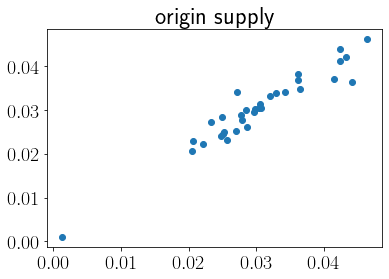

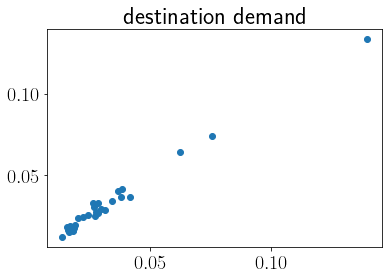

In [8]:
plt.figure(0)
plt.title('origin supply')
plt.scatter(ao,bo)
plt.show()

plt.figure(1)
plt.title('destination demand')
plt.scatter(d,np.exp(xd))
plt.show()

In [215]:
borough_polygons = borough_polygons.sort_values('borough_new')
borough_polygons['destination_size'] = 100*wd

ward_polygons = ward_polygons.sort_values('ward_new')
ward_polygons['origin_supply'] = 100*o

colormap = 'RdYlGn'

In [221]:
# borough_polygons.plot(figsize=(20,20),
#                       linewidth=0.5,
#                       column='destination_size',
#                       cmap=colormap, 
#                       legend=True,
#                       vmin=min(borough_polygons['destination_size']), 
#                       vmax=max(borough_polygons['destination_size']),
#                       legend_kwds={'label': r"$W_j$",
#                                    'orientation': "horizontal"})
# plt.yticks([])
# plt.xticks([])
# # for index, row in borough_polygons.iterrows():
# #     xy = row['geometry'].centroid.coords[:]
# #     xytext = row['geometry'].centroid.coords[:]
# #     plt.annotate(row['borough'], xy=xy[0], xytext=xytext[0], horizontalalignment='center', verticalalignment='center',color='blue')
# #     plt.axis('off')

# plt.savefig("../data/output/commuter_ward/actual/figures/destination_size.png",
#             dpi=1000, 
#             bbox_inches='tight',
#            transparent=True)

In [219]:
# ward_polygons.plot(figsize=(20,20),
#                       linewidth=0.5,
#                       column='origin_supply',
#                       cmap=colormap, 
#                       legend=True,
#                       vmin=min(ward_polygons['origin_supply']), 
#                       vmax=max(ward_polygons['origin_supply']),
#                       legend_kwds={'label': r"$O_i$",
#                                    'orientation': "horizontal"})
# plt.yticks([])
# plt.xticks([])
# # for index, row in borough_polygons.iterrows():
# #     xy = row['geometry'].centroid.coords[:]
# #     xytext = row['geometry'].centroid.coords[:]
# #     plt.annotate(row['borough'], xy=xy[0], xytext=xytext[0], horizontalalignment='center', verticalalignment='center',color='blue')
# #     plt.axis('off')

# plt.savefig("../data/output/commuter_ward/actual/figures/origin_supply.png",
#             dpi=1000, 
#             bbox_inches='tight',
#            transparent=True)

# Visualise destination sizes

In [85]:
# Set plot params
latent_factor = 10000
actual_factor = 10000

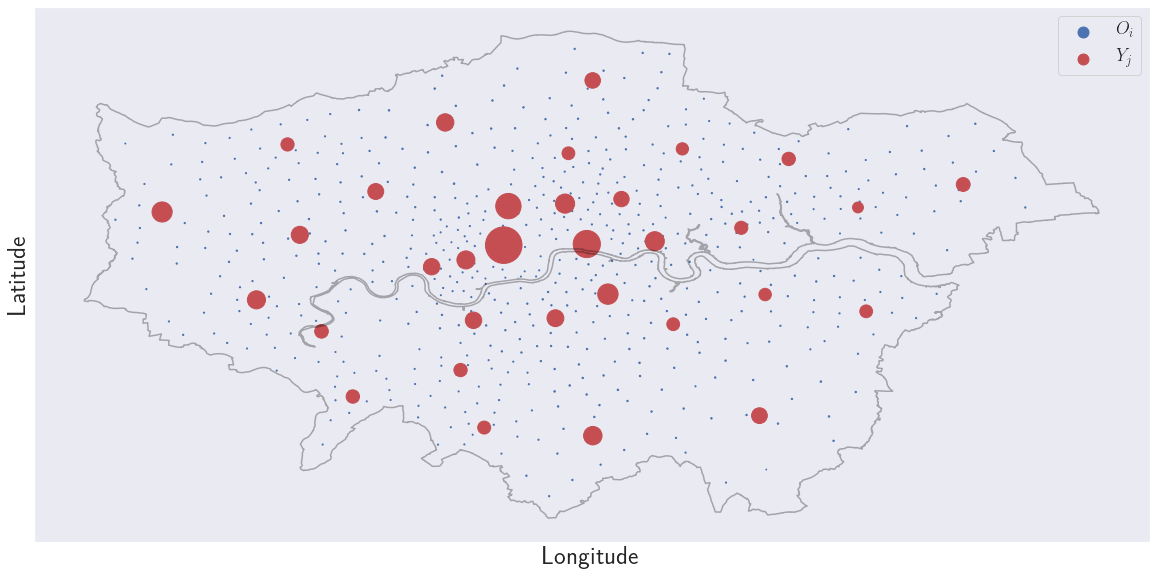

In [217]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(orig_locs[:, 0], orig_locs[:, 1], color='b',edgecolors='b', s=actual_factor*o, alpha=1,label=r'$O_i$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], color='r',edgecolors='r', s=latent_factor*np.exp(xd), alpha=1,label=r'$Y_j$')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=18)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [120]
plt.yticks([])
plt.xticks([])
plt.xlabel('Longitude',fontsize=25)
plt.ylabel('Latitude',fontsize=25)

london_boundary.boundary.plot(edgecolor='black',ax=ax,alpha=0.3)
plt.savefig("../data/output/commuter_ward/actual/figures/latent_sizes.png",
            dpi=1000, 
            bbox_inches='tight',
           transparent=True)

# Check convexity

In [87]:
def is_pos_semidef(M):
    return np.all(np.linalg.eigvals(M) >= 0)

def convexity_test(M):
    
    if is_pos_semidef(M):
        print('Potential function is convex.')
        return True
    else:
        print(f'alpha = {theta[0]}')
        print('Potential function is NOT convex.')
        return False

In [88]:
# si = SpatialInteraction(dataset)
# si.normalise_data()

# # Get destination sizes
# xd = si.normalised_initial_destination_sizes

# theta[0] = 1.01
# theta[1] = 0.04

# # Get hessian
# hessian = si.potential_hessian(xd,theta)

# # Run convexity test
# convexity_test(hessian)

# MCMC samples

## Low noise

### Sandbox

In [9]:
Ap = np.array([[ 0.00749674, 0.00182529], [ 0.00182529,  0.00709968]])
# print(Ap[0,0]/Ap[0,1])
# print(Ap[1,0]/Ap[1,1])
# t0 = np.array([1.1400000000000001,0.028571429])
# t0 = np.array([1.16,0.012857143])
t0 = np.array([1.13,0.03])

print(t0[0]/t0[1])
print(t0[1]/t0[0])

37.666666666666664
0.026548672566371685


In [10]:
Ap = np.array([[ 0.00749674,  0.00182529], [ 0.00182529,  0.00709968]])
# Ap = np.array([[ 0.01499348, 0.00365058], [ 0.00182529,  0.00709968]])


# Ap[0,0] = 0.00014398846809000215#0.0002199348
# Ap[0,1] = 0.000035058
# Ap[1,0] = 0.000035058 
# Ap[1,1] = 0.00014398846809000215

# Ap[0,0] = 0.01015014
# Ap[0,1] = 0.000182529
# Ap[1,0] = 0.000182529 
# Ap[1,1] = 0.01015014

# Ap[0,0] = 0.007355014
# Ap[0,1] = 0.000182529
# Ap[1,0] = 0.00182529 
# Ap[1,1] = 0.00309968

print(Ap[0,0]/Ap[0,1])
print(Ap[1,0]/Ap[1,1])

theta_step = 0.04
n = 20000
burnin = 0#10000
ideal_theta_ar = 0.45
_print = False

4.107150096696963
0.257094685957677


In [72]:
proposed_samples =  t0 + theta_step*np.random.multivariate_normal(np.zeros(2),np.dot(Ap,Ap.T),10000)

In [73]:
Ap

array([[0.00749674, 0.00182529],
       [0.00182529, 0.00709968]])

Alpha posterior


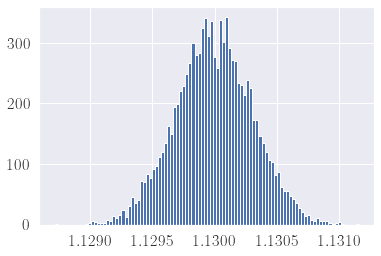

Beta posterior


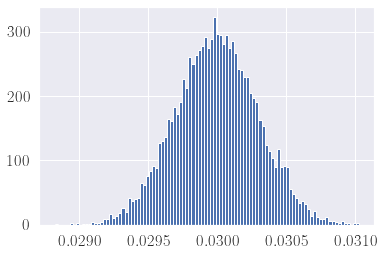

In [74]:
plt.figure(0)
print('Alpha posterior')
plt.hist(proposed_samples[:,0],bins=100)
plt.show()

plt.figure(1)
print('Beta posterior')
plt.hist(proposed_samples[:,1],bins=100)
plt.show()

In [75]:
# Proposal and acceptance count
pc = 0
ac = 0

np.random.seed(888)

theta_initial = np.array([1.13,0.03]) # np.array([1.14, 0.02]) #  np.array([1.17097421, 0.25761399])
fake_samples = np.zeros((n,2))
fake_samples[0,:] = samples[0,:]
print(f'----- initial theta = {theta_initial} -----')
for i in tqdm(range(n)):

    theta_proposal = theta_initial + theta_step*np.dot(Ap, np.random.normal(0, 1, 2))
    if _print:
        print(f'inital theta = {theta_initial}')
        print(f'proposal theta = {theta_proposal}')
    
    for j in range(2):
        if theta_proposal[j] < 0.:
            theta_proposal[j] = -theta_proposal[j]
        elif theta_proposal[j] > 2.:
            theta_proposal[j] = 2. - (theta_proposal[j] - 2.)
        
    pc += 1

    if np.random.uniform(0,1,1) <= ideal_theta_ar:# np.random.uniform(0.4,0.5,1):

#         if _print:
#             print(f'inital theta = {theta_initial}')
#             print(f'theta accepted = {theta_proposal}')

        theta_initial = theta_proposal
        ac += 1
        
#         if _print:
#             print(f'theta AR =  {int(100*ac/pc)}%')
            
    if (i+1) % 1000 == 0:
        if _print:
            print(f'Iteration {i+1}')
            print(f'inital theta = {theta_initial}')
            print(f'theta accepted = {theta_proposal}')
            print(f'theta AR =  {int(100*ac/pc)}%')
        
    fake_samples[i,:] = theta_initial

 13%|█▎        | 2583/20000 [00:00<00:00, 25829.84it/s]

----- initial theta = [1.13 0.03] -----


100%|██████████| 20000/20000 [00:00<00:00, 25259.35it/s]


In [ ]:
plt.figure(0)
plt.title("Alpha low noise")
print(f'RW mean = {np.mean(fake_samples[burnin:, 0])}')
print(f'alpha ratio = {np.mean(fake_samples[burnin:, 0])/1.4415421678393674}')
print(f'RW sd = {np.std(fake_samples[burnin:, 0])}')
plt.plot(fake_samples[burnin:, 0])
plt.xlim([0,n-burnin])
print('\n')

plt.figure(1)
plt.title("Beta low noise")
print(f'RW mean = {np.mean(fake_samples[burnin:, 1])}')
print(f'beta ratio = {np.mean(fake_samples[burnin:, 1])/3.2047518572770777}')
print(f'RW sd = {np.std(fake_samples[burnin:, 1])}')
plt.plot(fake_samples[burnin:, 1])
plt.xlim([0,n-burnin])
print('\n')

print('mean to sd ration', np.mean(fake_samples[burnin:, 0])/np.std(fake_samples[burnin:, 0]))
print('good mean to sd ratio',148.39001212239688)

In [ ]:
plt.figure(0)
print('Alpha ACF')
sm.graphics.tsa.plot_acf(fake_samples[burnin:,0], lags=50)
plt.show()

plt.figure(1)
print('Beta ACF')
sm.graphics.tsa.plot_acf(fake_samples[burnin:,1], lags=50)
plt.show()

### Produce posterior plots

In [27]:
# Choose whether to save the plot or not
low_save = False

# Last iteration 
last_it = -1

In [28]:
samples = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples{cost_matrix_file_extension}.txt"))
samples2 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_logsize_samples{cost_matrix_file_extension}.txt"))
samples3 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_sign_samples{cost_matrix_file_extension}.txt"))

if last_it == -1:
    last_it = samples.shape[0]

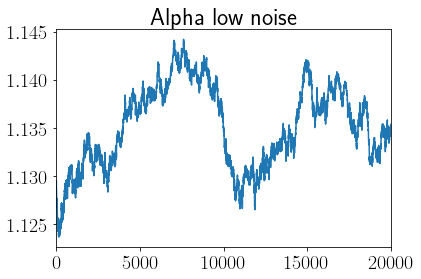

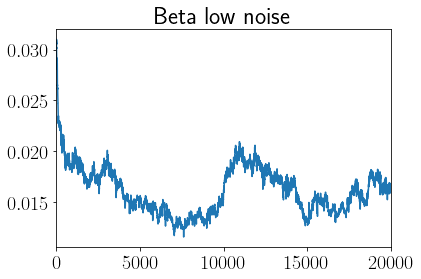

In [29]:
plt.figure(0)
plt.title("Alpha low noise")
plt.plot(samples[:last_it, 0])
plt.xlim([0,last_it])
plt.show()

plt.figure(0)
plt.title("Beta low noise")
plt.plot(samples[:last_it, 1])
plt.xlim([0,last_it])
plt.show()

Alpha posterior


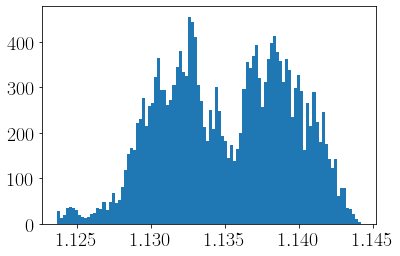

Beta posterior


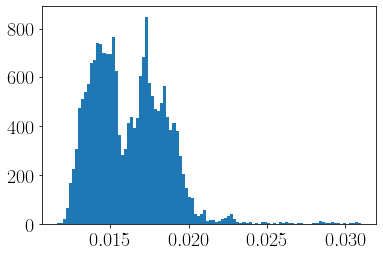

In [30]:
plt.figure(0)
print('Alpha posterior')
plt.hist(samples[:last_it,0],bins=100)
plt.show()

plt.figure(1)
print('Beta posterior')
plt.hist(samples[:last_it,1],bins=100)
plt.show()

Alpha ACF


<Figure size 432x288 with 0 Axes>

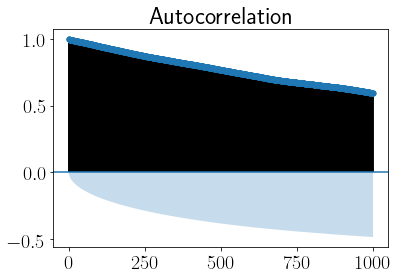

Beta ACF


<Figure size 432x288 with 0 Axes>

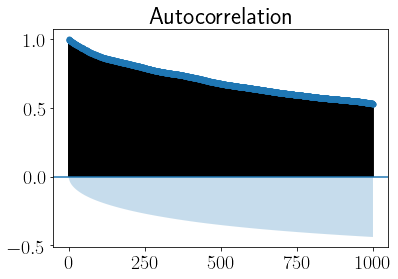

In [31]:
plt.figure(0)
print('Alpha ACF')
sm.graphics.tsa.plot_acf(samples[:last_it,0], lags=1000)
plt.show()

plt.figure(1)
print('Beta ACF')
sm.graphics.tsa.plot_acf(samples[:last_it,1], lags=1000)
plt.show()

In [32]:
alpha_mean = np.dot(samples3, samples[:, 0])/np.sum(samples3)
alpha_sd = np.sqrt(np.dot(samples3, samples[:, 0]**2)/np.sum(samples3) - alpha_mean**2)
print("Alpha mean: " + str(alpha_mean))
print("Alpha sd: " + str(alpha_sd))
beta_mean = np.dot(samples3, samples[:, 1])/np.sum(samples3)
beta_sd = np.sqrt(np.dot(samples3, samples[:, 1]**2)/np.sum(samples3) - beta_mean**2)
print("Beta mean: " + str(beta_mean))
print("Beta sd: " + str(beta_sd))

Alpha mean: 1.1351370418374023
Alpha sd: 0.004290350814706172
Beta mean: 0.016174626315154338
Beta sd: 0.002333218035160093


In [35]:
','.join(map(str,np.exp(low_posterior_xd_mean)))

'0.015315177874046657,0.026811078616787484,0.018100735160597136,0.025910926575239347,0.022023650832786682,0.05247836756669653,0.06436932731116252,0.026847670341084748,0.026368354571125192,0.022884425405743446,0.019480249229825948,0.02806444321568518,0.029642394031535214,0.021111946485483014,0.01861236415710276,0.017967187611224796,0.02535576854599674,0.026116674133174644,0.037910368600128135,0.034619357244857325,0.019112492663510883,0.031347702691827684,0.02123467406981674,0.021120019561934815,0.021495623231976704,0.019884488374428733,0.020392146457664434,0.04085603720825694,0.01895511389768031,0.03678065507685092,0.019269611161279305,0.029531143893954215,0.13327484718196927'

In [33]:
# Posterior latent sizes
low_posterior_wd_mean = (np.exp(samples2)*samples3[:, np.newaxis]).sum(axis=0)/np.sum(samples3)
low_posterior_wd_mean2 = (np.exp(2*samples2)*samples3[:, np.newaxis]).sum(axis=0)/np.sum(samples3)
low_posterior_wd_sd = np.sqrt(low_posterior_wd_mean2 - low_posterior_wd_mean**2)
low_posterior_xd_mean = np.log(low_posterior_wd_mean)

print('Posterior latent sizes mean')
print(np.exp(low_posterior_xd_mean))
print('Posterior latent sizes sd')
print(low_posterior_wd_sd)
print('Actual latent sizes')
print(np.exp(xd))

Posterior latent sizes mean
[0.01531518 0.02681108 0.01810074 0.02591093 0.02202365 0.05247837
 0.06436933 0.02684767 0.02636835 0.02288443 0.01948025 0.02806444
 0.02964239 0.02111195 0.01861236 0.01796719 0.02535577 0.02611667
 0.03791037 0.03461936 0.01911249 0.0313477  0.02123467 0.02112002
 0.02149562 0.01988449 0.02039215 0.04085604 0.01895511 0.03678066
 0.01926961 0.02953114 0.13327485]
Posterior latent sizes sd
[0.00115206 0.00194758 0.00133307 0.00193375 0.00157585 0.00425345
 0.00578937 0.00192327 0.00189924 0.00167775 0.00152771 0.00226082
 0.00231229 0.00161971 0.00138608 0.00130136 0.00181849 0.00184795
 0.00295386 0.00279041 0.0014152  0.00248511 0.00169125 0.00160565
 0.00163777 0.0014743  0.00151317 0.00314123 0.00141757 0.00297777
 0.00148413 0.00226486 0.013565  ]
Actual latent sizes
[0.01178782 0.03012443 0.01637197 0.02532198 0.0248854  0.06417813
 0.07400131 0.0340537  0.02925126 0.02423052 0.0154988  0.02357564
 0.02685003 0.01637197 0.01746344 0.01920978 0.04038

In [146]:
# # Posterior latent sizes
# posterior_xd_mean = np.mean(samples2,axis=0)
# posterior_xd_sd = np.std(samples2,axis=0)
# print('Posterior latent sizes mean')
# print(np.exp(posterior_xd_mean))
# print('Posterior latent sizes sd')
# print(posterior_xd_sd)
# print('Actual latent sizes')
# print(np.exp(xd))

In [147]:
# Set factor for plotting
actual_factor = 1000
latent_factor = 10000

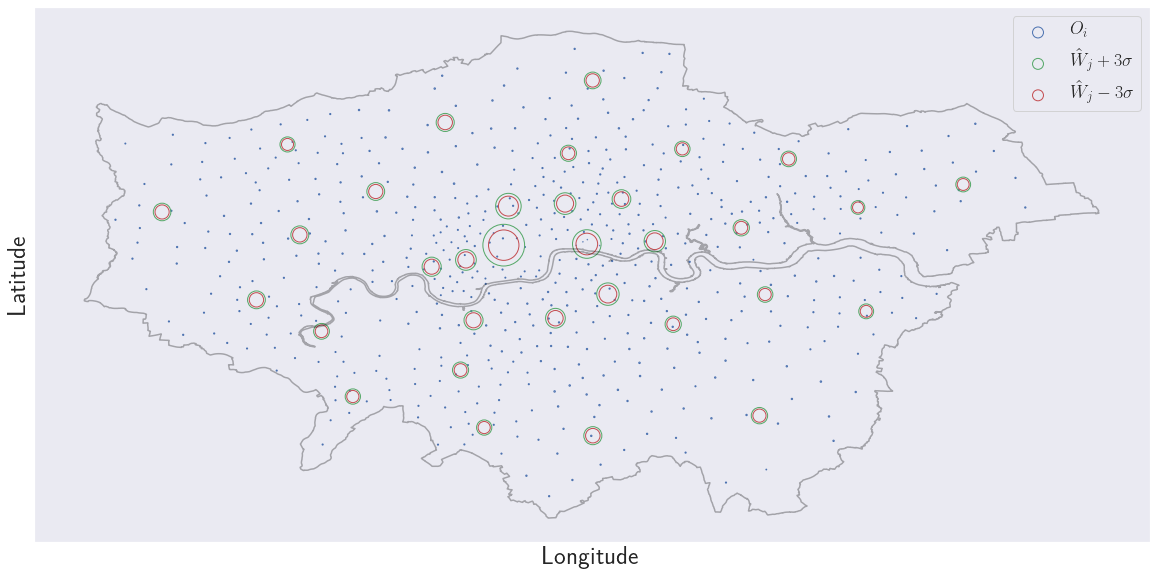

In [115]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(orig_locs[:, 0], orig_locs[:, 1], facecolor="None",edgecolors='b', s=actual_factor*o, alpha=1,label=r'$O_i$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='g', s=latent_factor*(low_posterior_wd_mean+3*low_posterior_wd_sd), alpha=1,label=r'$\hat{W}_j+3\sigma$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='r', s=latent_factor*(low_posterior_wd_mean-3*low_posterior_wd_sd), alpha=1,label=r'$\hat{W}_j-3\sigma$')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=18)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [120]
plt.yticks([])
plt.xticks([])
plt.xlabel('Longitude',fontsize=25)
plt.ylabel('Latitude',fontsize=25)

london_boundary.boundary.plot(edgecolor='black',ax=ax,alpha=0.3)
if low_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/low_noise_posterior_latent_sizes{cost_matrix_file_extension}.png",
            dpi=1000, 
            bbox_inches='tight',transparent=True)

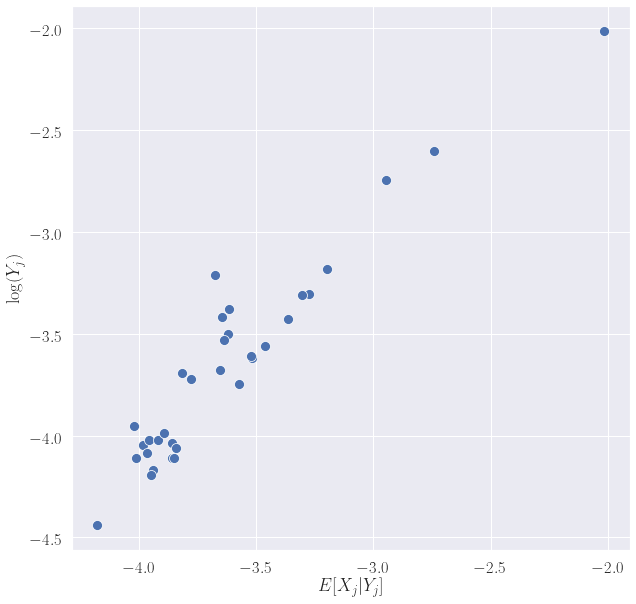

In [116]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=low_posterior_xd_mean, y=xd, s=100)
ax = ax.set(ylabel=r'$\log(Y_j)$', xlabel=r'$E[X_j|Y_j]$')

if low_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/low_noise_predictions_plot{cost_matrix_file_extension}.png",
                dpi=1000, 
                bbox_inches='tight',
                transparent=True)

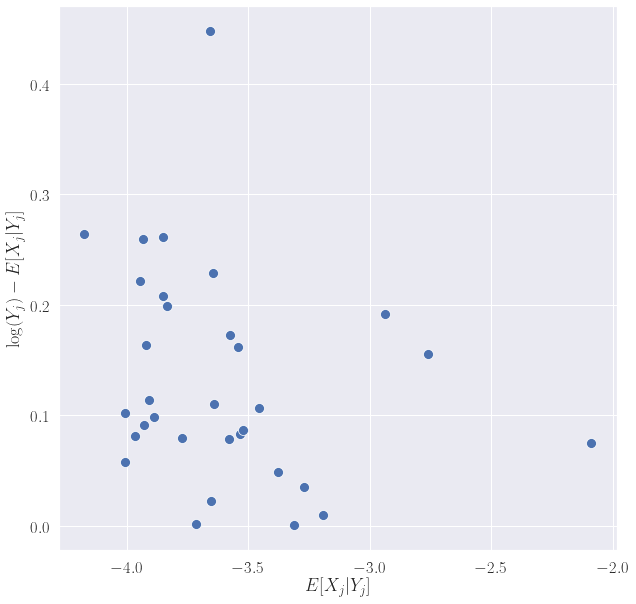

In [34]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=low_posterior_xd_mean, y=abs(xd-low_posterior_xd_mean), s=100)
ax = ax.set(ylabel=r'$\log(Y_j)-E[X_j|Y_j]$', xlabel=r'$E[X_j|Y_j]$')

if low_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/low_noise_residual_plot{cost_matrix_file_extension}.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)

In [155]:
np.corrcoef(low_posterior_xd_mean,xd)[0,1]

0.9585629559004405

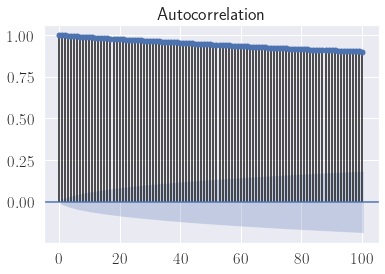

In [156]:
sm.graphics.tsa.plot_acf(samples[:,0], lags=100)
plt.show()

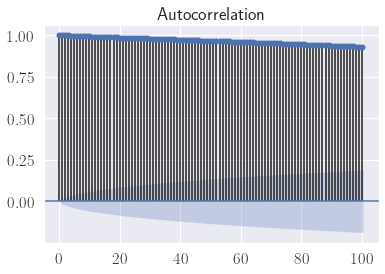

In [157]:
sm.graphics.tsa.plot_acf(samples[:,1], lags=100)
plt.show()

In [38]:
print(np.mean(samples[::1500],axis=0))
print(np.std(samples[::1500],axis=0))

[1.14265318 0.02595177]
[0.00464759 0.00329797]


In [39]:
# Define number of steps to skip based on ACF
steps = 1

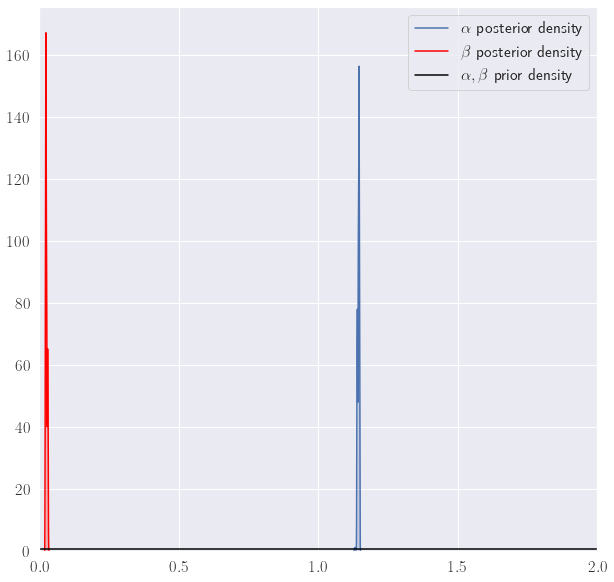

In [40]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.kdeplot(data=samples[::steps,0], label=r'$\alpha$ posterior density',shade=True)
ax = sns.kdeplot(data=samples[::steps,1], label=r'$\beta$ posterior density',color='red',shade=True)
plt.axhline(0.5, color='black',label=r'$\alpha,\beta$ prior density')
ax1 = ax.set(xlim=(0, 2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

labels = [r'$\alpha$ posterior density', r'$\beta$ posterior density', r'$\alpha,\beta$ prior density']
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles[0:], labels = labels)


if low_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/low_noise_parameter_posterior{cost_matrix_file_extension}.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)


## High noise

In [60]:
# Select starting point
mcmc_start = 10000
last_iteration = mcmc_start + 10000
# Choose whether to save plots
high_save = False

In [44]:
# Import samples
high_samples = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_theta_samples{cost_matrix_file_extension}_final.txt"))
high_samples2 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_logsize_samples{cost_matrix_file_extension}_final.txt"))
high_samples3 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_sign_samples{cost_matrix_file_extension}_final.txt"))

# Import samples
high_samples_initial = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_theta_samples{cost_matrix_file_extension}_initial.txt"))
high_samples_initial2 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_logsize_samples{cost_matrix_file_extension}_initial.txt"))
high_samples_initial3 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_sign_samples{cost_matrix_file_extension}_initial.txt"))

In [45]:
# Start from mcmc_start
high_samples = high_samples[mcmc_start:last_iteration]
high_samples2 = high_samples2[mcmc_start:last_iteration]
high_samples3 = high_samples3[mcmc_start:last_iteration]

In [46]:
steps = 1

In [47]:
# high_alpha_mean = np.dot(high_samples3[mcmc_start:last_iteration:steps], high_samples[mcmc_start:last_iteration:steps, 0])/np.sum(high_samples3[mcmc_start:last_iteration:steps])
# high_alpha_sd = np.sqrt(np.dot(high_samples3[mcmc_start:last_iteration:steps], high_samples[mcmc_start:last_iteration:steps, 0]**2)/np.sum(high_samples3[mcmc_start:last_iteration:steps]) - high_alpha_mean**2)
# high_beta_mean = np.dot(high_samples3[mcmc_start:last_iteration:steps], high_samples[mcmc_start:last_iteration:steps, 1])/np.sum(high_samples3[mcmc_start:last_iteration:steps])
# high_beta_sd = np.sqrt(np.dot(high_samples3[mcmc_start:last_iteration:steps], high_samples[mcmc_start:last_iteration:steps, 1]**2)/np.sum(high_samples3[mcmc_start:last_iteration:steps]) - high_beta_mean**2)

# print('Theta mean')
# print('alpha = ',high_alpha_mean)
# print('beta = ',high_beta_mean)
# print('Theta sd')
# print('alpha = ',high_alpha_sd)
# print('beta = ',high_beta_sd)

high_alpha_mean = np.dot(high_samples3[::steps], high_samples[::steps, 0])/np.sum(high_samples3[::steps])
high_alpha_sd = np.sqrt(np.dot(high_samples3[::steps], high_samples[::steps, 0]**2)/np.sum(high_samples3[::steps]) - high_alpha_mean**2)
high_beta_mean = np.dot(high_samples3[::steps], high_samples[::steps, 1])/np.sum(high_samples3[::steps])
high_beta_sd = np.sqrt(np.dot(high_samples3[::steps], high_samples[::steps, 1]**2)/np.sum(high_samples3[::steps]) - high_beta_mean**2)

print('Theta mean')
print('alpha = ',high_alpha_mean)
print('beta = ',high_beta_mean)
print('Theta sd')
print('alpha = ',high_alpha_sd)
print('beta = ',high_beta_sd)

Theta mean
alpha =  0.23338040309955535
beta =  0.12498763274450253
Theta sd
alpha =  0.18432949907186463
beta =  0.20445797459026813


In [48]:
# # Posterior latent sizes
# high_posterior_wd_mean = (np.exp(high_samples2[mcmc_start:last_iteration:steps])*high_samples3[mcmc_start:last_iteration:steps, np.newaxis]).sum(axis=0)/np.sum(high_samples3[mcmc_start:last_iteration:steps])
# high_posterior_wd_mean2 = (np.exp(2*high_samples2[mcmc_start:last_iteration:steps])*high_samples3[mcmc_start:last_iteration:steps, np.newaxis]).sum(axis=0)/np.sum(high_samples3[mcmc_start:last_iteration:steps])
# high_posterior_wd_sd = np.sqrt(high_posterior_wd_mean2 - high_posterior_wd_mean**2)
# high_posterior_xd_mean = np.log(high_posterior_wd_mean)

# print('Posterior latent sizes mean')
# print(np.exp(high_posterior_xd_mean))
# print('Posterior latent sizes sd')
# print(high_posterior_wd_sd)
# print('Actual latent sizes')
# print(np.exp(xd))

# Posterior latent sizes
high_posterior_wd_mean = (np.exp(high_samples2[::steps])*high_samples3[::steps, np.newaxis]).sum(axis=0)/np.sum(high_samples3[::steps])
high_posterior_wd_mean2 = (np.exp(2*high_samples2[::steps])*high_samples3[::steps, np.newaxis]).sum(axis=0)/np.sum(high_samples3[::steps])
high_posterior_wd_sd = np.sqrt(high_posterior_wd_mean2 - high_posterior_wd_mean**2)
high_posterior_xd_mean = np.log(high_posterior_wd_mean)

print('Posterior latent sizes mean')
print(np.exp(high_posterior_xd_mean))
print('Posterior latent sizes sd')
print(high_posterior_wd_sd)
print('Actual latent sizes')
print(np.exp(xd))

Posterior latent sizes mean
[0.01208559 0.0301875  0.01664935 0.02561508 0.02500212 0.06231693
 0.07120561 0.03397005 0.0294578  0.024394   0.01585433 0.02400428
 0.02719989 0.01675203 0.01773296 0.01941132 0.03980872 0.03270464
 0.03679499 0.03277849 0.01812414 0.02874812 0.01676873 0.01804732
 0.01765307 0.01820284 0.01881533 0.04143669 0.01709295 0.03653884
 0.01540842 0.02740623 0.12066511]
Posterior latent sizes sd
[0.00119611 0.00301096 0.00167139 0.00251624 0.00248623 0.00599817
 0.00669852 0.00334744 0.00289653 0.00243035 0.00156709 0.00234621
 0.00265524 0.00167966 0.00175872 0.00194015 0.00387719 0.00324266
 0.00355471 0.00330321 0.00183072 0.00287457 0.00166924 0.00180327
 0.00180919 0.00181902 0.00184459 0.00403351 0.00168811 0.00355843
 0.00152871 0.00273302 0.01134597]
Actual latent sizes
[0.01178782 0.03012443 0.01637197 0.02532198 0.0248854  0.06417813
 0.07400131 0.0340537  0.02925126 0.02423052 0.0154988  0.02357564
 0.02685003 0.01637197 0.01746344 0.01920978 0.04038

In [49]:
# Set factor for plotting
actual_factor = 1000
latent_factor = 10000

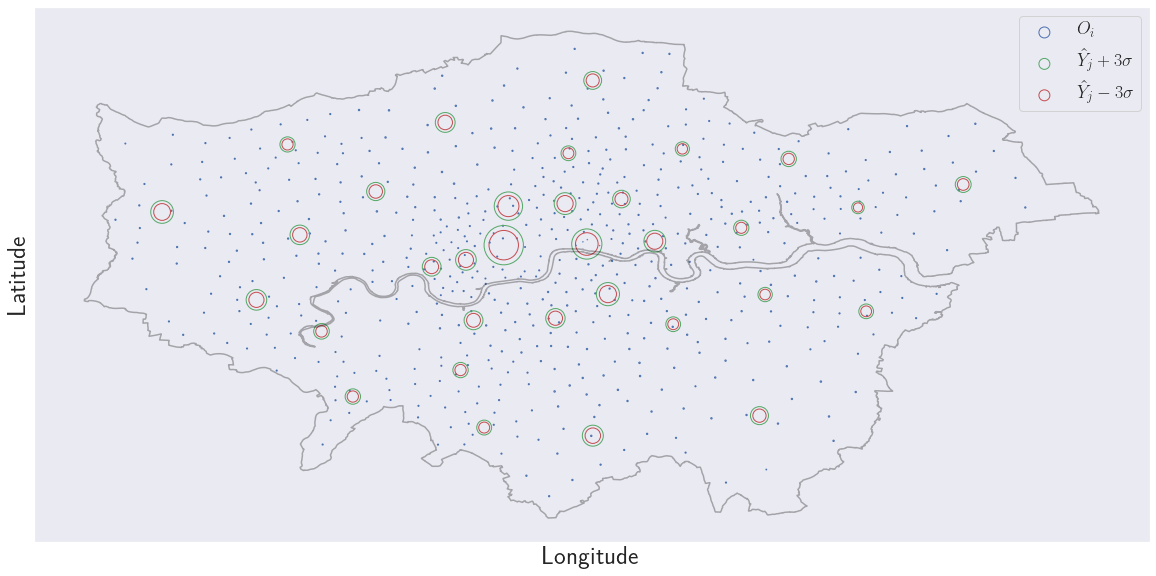

In [50]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(orig_locs[:, 0], orig_locs[:, 1], facecolor="None",edgecolors='b', s=actual_factor*o, alpha=1,label=r'$O_i$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='g', s=latent_factor*(high_posterior_wd_mean+3*high_posterior_wd_sd), alpha=1,label=r'$\hat{Y}_j+3\sigma$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='r', s=latent_factor*(high_posterior_wd_mean-3*high_posterior_wd_sd), alpha=1,label=r'$\hat{Y}_j-3\sigma$')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=18)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [120]
plt.yticks([])
plt.xticks([])
plt.xlabel('Longitude',fontsize=25)
plt.ylabel('Latitude',fontsize=25)

london_boundary.boundary.plot(edgecolor='black',ax=ax,alpha=0.3)

if high_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/high_noise_posterior_latent_sizes{cost_matrix_file_extension}.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)

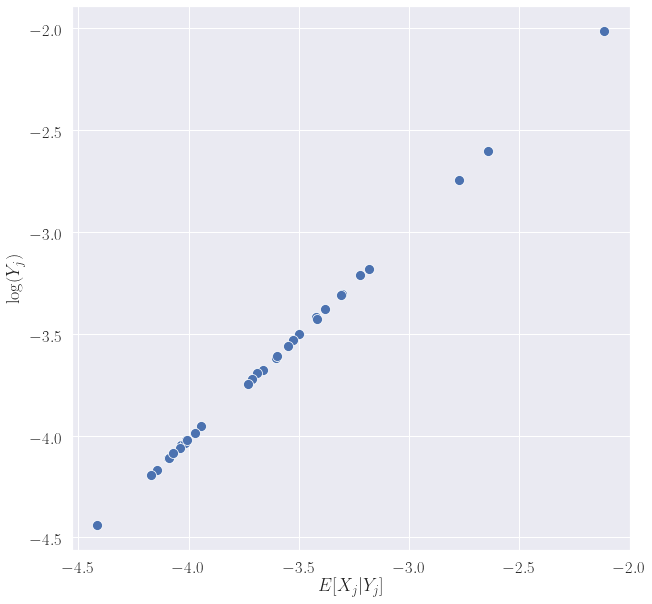

In [51]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=high_posterior_xd_mean, y=xd, s=100)
ax = ax.set(ylabel=r'$\log(Y_j)$', xlabel=r'$E[X_j|Y_j]$')


if high_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/high_noise_predictions_plot{cost_matrix_file_extension}.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)

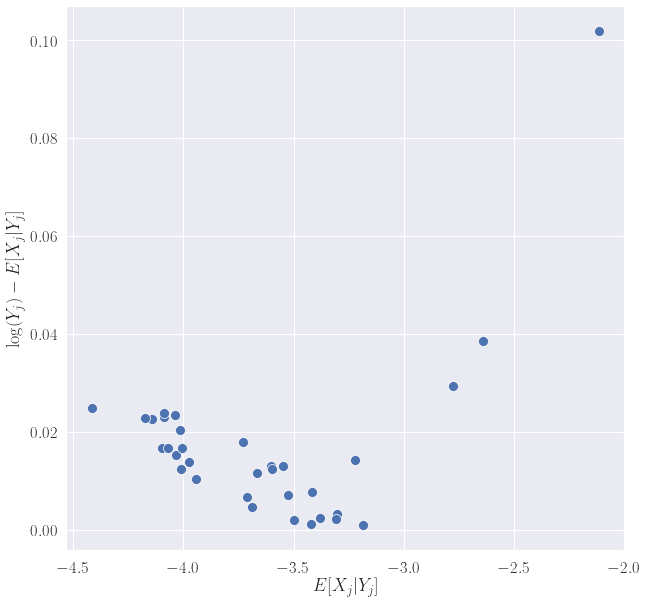

In [52]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=high_posterior_xd_mean, y=abs(xd-high_posterior_xd_mean), s=100)
ax = ax.set(ylabel=r'$\log(Y_j)-E[X_j|Y_j]$', xlabel=r'$E[X_j|Y_j]$')

if high_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/high_noise_residual_plot{cost_matrix_file_extension}.png",
            dpi=1000, 
            bbox_inches='tight',
           transparent=True)

In [53]:
np.corrcoef(high_posterior_xd_mean,xd)[0,1]

0.9997986054370639

(0.0, 10000.0)

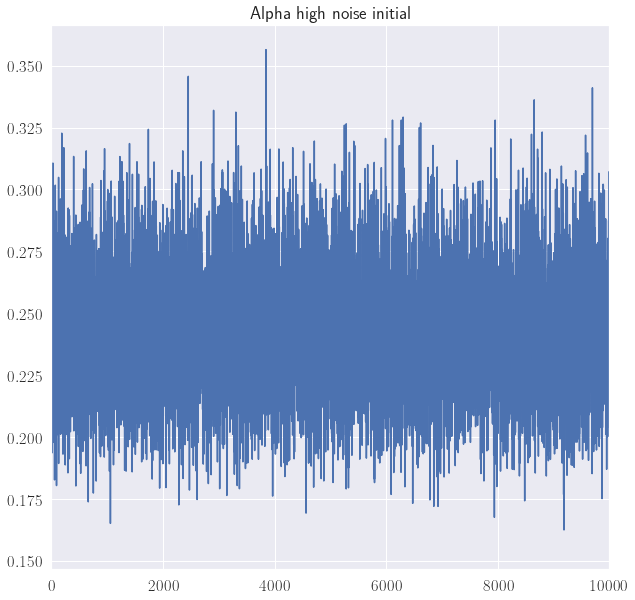

In [54]:
plt.figure(figsize=(10,10))
plt.title("Alpha high noise initial")
plt.plot(high_samples_initial[:, 0])
plt.xlim([0,10000])

(0.0, 10000.0)

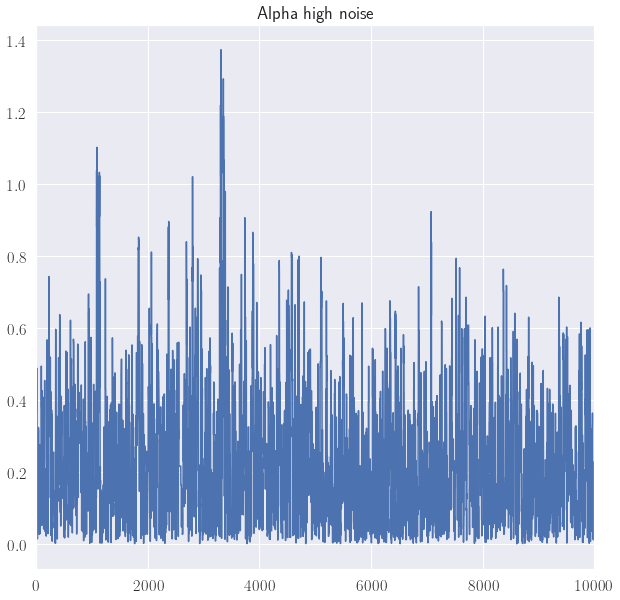

In [55]:
plt.figure(figsize=(10,10))
plt.title("Alpha high noise")
plt.plot(high_samples[:, 0])
plt.xlim([0,(last_iteration-mcmc_start)])

(0.0, 10000.0)

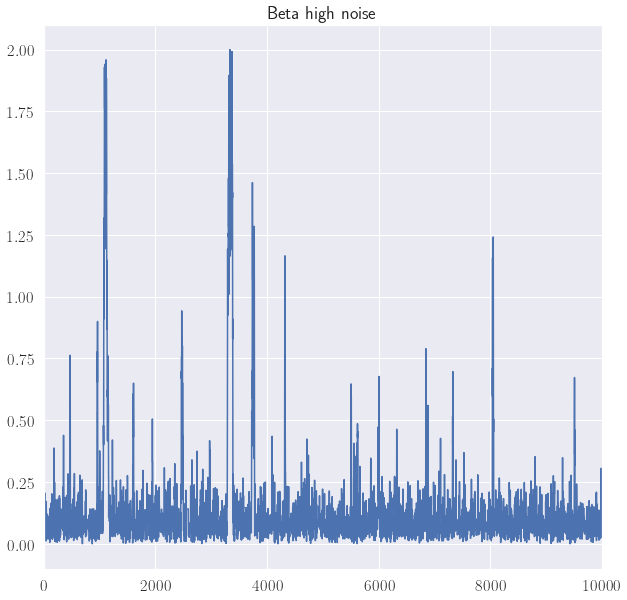

In [56]:
plt.figure(figsize=(10,10))
plt.title("Beta high noise")
plt.plot(high_samples[:, 1])
plt.xlim([0,(last_iteration-mcmc_start)])

Alpha high noise ACF


<Figure size 432x288 with 0 Axes>

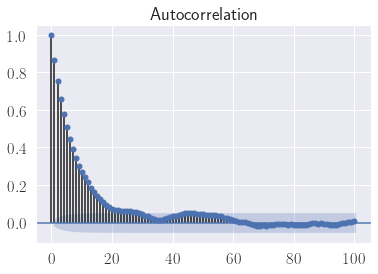

Beta high noise ACF


<Figure size 432x288 with 0 Axes>

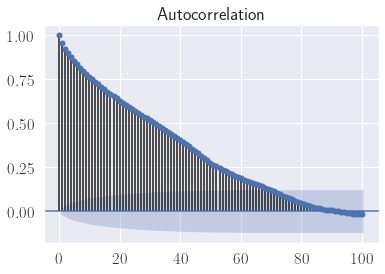

In [57]:
plt.figure(0)
print('Alpha high noise ACF')
sm.graphics.tsa.plot_acf(high_samples[:,0], lags=100)
plt.show()

plt.figure(1)
print('Beta high noise ACF')
sm.graphics.tsa.plot_acf(high_samples[:, 1], lags=100)
plt.show()

In [32]:
# Define number of steps to skip based on ACF
steps = 50

In [65]:
high_save = False

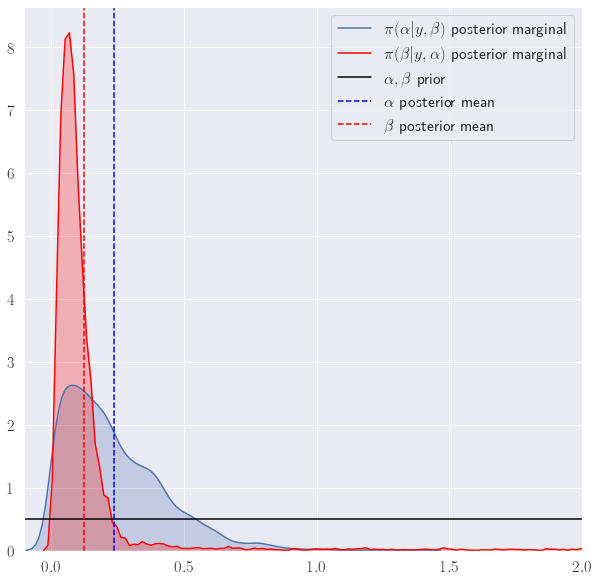

In [64]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax1 = sns.kdeplot(data=high_samples[::steps,0], label=r'$\pi(\alpha|y,\beta)$ posterior marginal',shade=True)
ax2 = sns.kdeplot(data=high_samples[::steps,1], label=r'$\pi(\beta|y,\alpha)$ posterior marginal',color='red',shade=True)
ax3 = ax1.axhline(0.5, color='black',label=r'$\alpha,\beta$ prior')
ax4 = ax1.axvline(np.mean(high_samples[::steps],axis=0)[0], color='blue',ls='--',label=r'$\alpha$ posterior mean')
ax5 = ax2.axvline(np.mean(high_samples[::steps],axis=0)[1], color='red',ls='--',label=r'$\beta$ posterior mean')
# ax6 = ax2.axvline(0.11507332679980924, color='green',ls='--',label=r'$\beta$ posterior mode')
# ax6 = ax2.axvline(0.08566811795636758, color='yellow',ls='--',label=r'$\alpha$ posterior mode')

ax6 = ax1.set(xlim=(-0.1, 2))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

labels = [r'$\pi(\alpha|y,\beta)$ posterior marginal', r'$\pi(\beta|y,\alpha)$ posterior marginal', r'$\alpha,\beta$ prior', r'$\alpha$ posterior mean', r'$\beta$ posterior mean']
handles, _ = ax1.get_legend_handles_labels()
plt.legend(handles = handles[0:], labels = labels)

if high_save:
    plt.savefig(f"../data/output/commuter_ward/inverse_problem/figures/high_noise_parameter_posterior{cost_matrix_file_extension}.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)

# Compare population origin supply to borough commuter origin supply

In [189]:
# Import borough supply
origin_supply_borough = np.loadtxt(os.path.join(rd,f'./data/input/commuter_borough/origin_supply.txt'))
ob = origin_supply_borough/np.sum(origin_supply_borough)
boroughs = np.loadtxt(os.path.join(rd,f'./data/input/commuter_borough/origins.txt'),dtype=str)
wards = np.loadtxt(os.path.join(rd,f'./data/input/commuter_ward/origins.txt'),dtype=str)

# Create borough df
borough_df = pd.DataFrame(data=np.array([boroughs,ob]).T,columns=['borough','borough_origin'])

# Import ward to borough map
with open(os.path.join(rd,f'data/input/misc/ward_coordinates.json')) as infile:
    ward_coords = json.load(infile)

# Convert ward coordinates to dataframe
ward_properties = [x['properties'] for x in ward_coords['features']]
wards_df = pd.DataFrame.from_records(ward_properties)

# Sort wards_df
wards_df = wards_df.sort_values('ward_new')

# Add ward origin supply
wards_df['ward_origin'] = o

# Join ward to borough df
wards_df = wards_df[['ward_new','borough_new','ward_origin']]

# Get ward origin supply by borough
population_by_borough = wards_df.groupby('borough_new').sum().sort_values('borough_new')
ow = population_by_borough['ward_origin'].values

In [228]:
wards_df

,ward_new,borough_new,ward_origin
608,AbbeyRoad,Westminster,0.001332
192,AbbeyWood,Greenwich,0.001864
0,Abbey_BarkingandDagenham,BarkingandDagenham,0.001423
433,Abbey_Merton,Merton,0.001328
360,Abingdon,KensingtonandChelsea,0.001262
...,...,...,...
208,WoolwichRiverside,Greenwich,0.001780
550,WorcesterPark,Sutton,0.001377
243,WormholtandWhiteCity,HammersmithandFulham,0.001673
322,Yeading,Hillingdon,0.001662


In [190]:
ow

array([0.02285861, 0.04385945, 0.0304384 , 0.03673461, 0.04120653,
       0.0276098 , 0.00100055, 0.04609353, 0.04196098, 0.03814215,
       0.02989407, 0.02827962, 0.02303958, 0.03018743, 0.02883594,
       0.03126689, 0.03388231, 0.02960657, 0.02451126, 0.02215797,
       0.02053404, 0.03711177, 0.03470703, 0.02619989, 0.03400556,
       0.03327272, 0.02402898, 0.03414151, 0.02506494, 0.02734293,
       0.03044314, 0.03630461, 0.02527659])

In [191]:
ob

array([0.02061388, 0.04234396, 0.03035825, 0.03624706, 0.04245229,
       0.02795389, 0.00131891, 0.04632537, 0.04320524, 0.03622633,
       0.02853237, 0.02494888, 0.02571578, 0.02978764, 0.02776869,
       0.03052593, 0.0329993 , 0.02965929, 0.02514731, 0.02215124,
       0.02049911, 0.04151056, 0.03645085, 0.02862568, 0.02714624,
       0.03205972, 0.02481338, 0.03425064, 0.02518735, 0.02331535,
       0.03070291, 0.04411478, 0.02704184])

In [192]:
np.corrcoef(ow,ob)[0,1]

0.9598719852317978

In [193]:
ow/ob

array([1.10889393, 1.03579022, 1.00264019, 1.01345078, 0.97065522,
       0.98769084, 0.75861302, 0.99499553, 0.97120139, 1.05288494,
       1.04772493, 1.13350242, 0.89593193, 1.01342135, 1.03843362,
       1.02427317, 1.0267585 , 0.99822247, 0.97470712, 1.0003039 ,
       1.00170378, 0.89403201, 0.95215969, 0.91525826, 1.25268055,
       1.0378358 , 0.96838783, 0.99681378, 0.99513975, 1.17274401,
       0.99153947, 0.82295805, 0.9347215 ])

In [ ]:
np.log(ow)/np.log(ob)

In [ ]:
factor = 1e5

plt.figure(figsize=(20,20))
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='b', s=factor*ow, alpha=1,label='Ward orig supply')
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='g', s=factor*ob, alpha=1,label='Actual borough orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

# Aggregate cost matrix to borough level

In [263]:
naive_cost_matrix = pd.read_csv(f'../data/input/{dataset}/cost_matrix.csv',index_col=0)
informative_cost_matrix = pd.read_csv(f'../data/input/{dataset}/cost_matrix_small_network.csv',index_col=0)

ncm = naive_cost_matrix/np.sum(naive_cost_matrix)
icm = informative_cost_matrix/np.sum(informative_cost_matrix)

# Import ward to borough map
with open(os.path.join(rd,f'data/input/misc/ward_coordinates.json')) as infile:
    ward_coords = json.load(infile)

# Convert ward coordinates to dataframe
ward_properties = [x['properties'] for x in ward_coords['features']]
wards_df = pd.DataFrame.from_records(ward_properties)

# Aggregate naive cost matrix to borough level
ncm = ncm.reset_index()
ncm = ncm.rename(columns={'index':'ward_new'})
ncm_merged = pd.merge(ncm,wards_df[['ward_new','borough_new']],how='left')
ncm_merged = ncm_merged.drop(columns=['ward_new'])
ncm_merged = ncm_merged.groupby('borough_new').sum()

# Aggregate informative cost matrix to borough level
icm = icm.reset_index()
icm = icm.rename(columns={'index':'ward_new'})
icm_merged = pd.merge(icm,wards_df[['ward_new','borough_new']],how='left')
icm_merged = icm_merged.drop(columns=['ward_new'])
icm_merged = icm_merged.groupby('borough_new').sum()


## Export data

In [267]:
ncm_merged.to_csv('../data/input/commuter_ward/cost_matrix_borough.csv')
np.savetxt('../data/input/commuter_ward/cost_matrix_borough.txt',ncm_merged)

In [268]:
icm_merged.to_csv('../data/input/commuter_ward/cost_matrix_small_network_borough.csv')
np.savetxt('../data/input/commuter_ward/cost_matrix_small_network_borough.txt',icm_merged)